In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import scipy.stats as st
np.seterr(divide = 'ignore')
from cycler import cycler
from pandas import *
from astropy.coordinates import SkyCoord
import pandas as pd
from astropy.table import Table
import astropy.units as u
import mpl_toolkits.mplot3d.axes3d as axes3d
import statistics 

# ORION NEBULA CLUSTER STAR CATALOG

In [2]:
# catalog_orion = read_csv("ONC_gaiaedr3_cone_0.5deg.csv")
catalog_orion = read_csv("./Catalogs/ONC_gaiaedr3&apogee_cone_0.5deg.csv")
parallax_min=0.5
parallax_max=4


catalog_orion = catalog_orion.loc[(catalog_orion['parallax']>=parallax_min)]
catalog_orion = catalog_orion.loc[catalog_orion['parallax']<=parallax_max]

catalog_orion['parallax']=catalog_orion['parallax'].apply(lambda x: round(x,2))

catalog_orion.reset_index(inplace=True)

# ORION CLUSTER DATA

In [3]:
ori_center = SkyCoord("5h35m15.68s -5d23m40s", frame='icrs', unit = "deg")
ori_dist = 403 # [pc]
par_ori = 2.48/1000 #Paralaje [arcsec]
ori_ra = 83.81533333*0.0174533# [rad] 
ori_dec = -5.39444444*0.0174533 # [rad]
v_rad_ori = 21.8 #Velocidad radial [km/s]
prop_ra_ori =  1.96 #Proper Motion [mas/yr]
prop_dec_ori = -0.77 #Proper Motion [mas/yr]
kappa = 4.74 #Convertion Factor mas/yr -> km/s (d>1kpc)

# ORION STARS DATA

In [4]:
ra_stars = catalog_orion["ra"]*0.0174533 #[rad]
ra_err_stars = catalog_orion["ra_error"]*0.0174533 #[rad]
dec_stars = catalog_orion["dec"]*0.0174533 #[rad] 
dec_err_stars = catalog_orion["dec_error"]*0.0174533 #[rad]


# pmra to pmra 2
prop_ra_stars = catalog_orion["pmra_2"]*np.cos(dec_stars) #[mas/yr]
prop_dec_stars = catalog_orion["pmdec"] #[mas/yr]
parallax_stars = catalog_orion["parallax"]/1000 #[arcsec]
parallax_err_stars = catalog_orion["parallax_error"]/1000 #[arcsec]
ruwe_orion = catalog_orion["ruwe"]
rad_vel = catalog_orion["dr2_radial_velocity"]
rad_vel_err = catalog_orion["dr2_radial_velocity_error"]
sum(rad_vel_err[rad_vel_err>0])/len(rad_vel_err[rad_vel_err>0])

5.544480389299997

# Adapting Orion Stars to the XY Positions

In [5]:
x_ref_stars = (np.cos(dec_stars)*np.sin(ra_stars - ori_ra)) #~[rad]
y_ref_stars = (np.sin(dec_stars)*np.cos(ori_dec) - np.cos(dec_stars)*np.sin(ori_dec)*np.cos(ra_stars - ori_ra)) #~[rad]

### Distance between stars

In [6]:
dist_xy = np.sqrt(x_ref_stars**2 + y_ref_stars**2) #[rad], orthographic distance
dist_xy_mas=dist_xy*10**3*3600/0.0174533 #~[mas] The proper motions are converted to radians really, this is usefull to tracebacktime.  

# Adapting Orion Stars to the XY reference frame of rest

### Perspective Expansion

In [7]:
mu_ra_per_ori = (ra_stars-ori_ra)*(prop_dec_ori*np.sin(ori_dec) - (v_rad_ori*par_ori)/kappa*np.cos(ori_dec)) 
mu_dec_per_ori = -(ra_stars-ori_ra)*prop_ra_ori*np.sin(ori_dec) - (dec_stars-ori_dec)*(v_rad_ori*par_ori)/kappa

In [8]:
prop_obs_ra_ori = prop_ra_stars - prop_ra_ori
prop_obs_dec_ori = prop_dec_stars - prop_dec_ori
prop_rest_ra_ori = -(prop_obs_ra_ori - mu_ra_per_ori)
prop_rest_dec_ori = prop_obs_dec_ori - mu_dec_per_ori

### XY proper motions velocity

In [9]:
prop_x_ori = prop_rest_ra_ori*np.cos(ra_stars - ori_ra) - prop_rest_dec_ori*np.sin(dec_stars)*np.sin(ra_stars - ori_ra) #[mas/yr]
prop_y_ori = prop_rest_ra_ori*np.sin(ori_dec)*np.sin(ra_stars - ori_ra) + prop_rest_dec_ori*(np.cos(dec_stars)*np.cos(ori_dec) 
+ np.sin(dec_stars)*np.sin(ori_dec)*np.cos(ra_stars - ori_ra)) #[mas/yr]

### Total Velocity Orion Stars

In [10]:
pm_xy_ori = np.sqrt(prop_x_ori**2 + prop_y_ori**2) #[mas/yr]
pm_xy_ori_kms=pm_xy_ori/(par_ori*1000)*4.74

## Positions plot of the Stars

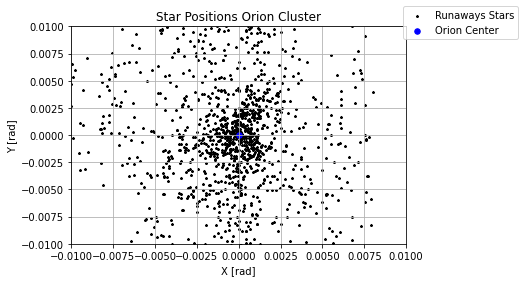

In [11]:
plt.scatter(x_ref_stars, y_ref_stars, marker = "*",s=5,color ="black", label = "Runaways Stars")
plt.scatter(0, 0, marker = "o",color ="blue", s=30, label = "Orion Center")
plt.title("Star Positions Orion Cluster")
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=-2)
plt.xlabel("X [rad]")
plt.ylabel("Y [rad]")
plt.xlim(-0.01,0.01)
plt.ylim(-0.01,0.01)
#plt.savefig('OrionStars.jpg', dpi=300)
plt.grid()
plt.show()

# CATALOG DATA PROPERTIES

## Velocity 2D Histogram

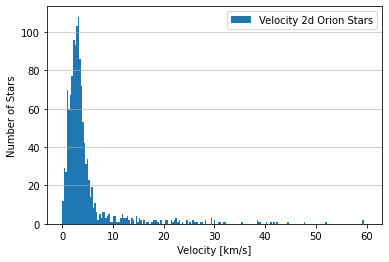

In [12]:
bins = np.linspace(0, 60, 200)
#plt.hist([mod_vel_2d,mod_vel_ori_2d], bins = bins,
#         label=['Velocity 2d Trapezium Runaways', "Velocity 2d Orion Stars"])

#plt.hist(mod_vel_2d, bins = bins)
plt.hist(pm_xy_ori_kms, bins = bins,label=['Velocity 2d Orion Stars', "Velocity 2d Orion Stars"])

plt.legend(loc='upper right')
plt.xlabel("Velocity [km/s]")
plt.ylabel("Number of Stars")
#plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
#plt.savefig('2dVelocitiesOrion2.png', dpi=300)
plt.show()

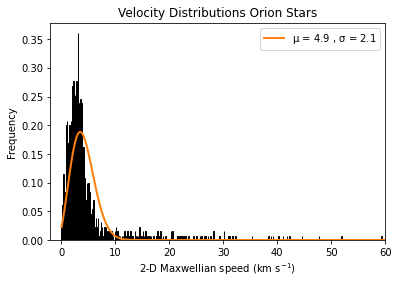

In [13]:
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import random
import numpy as np
import scipy.optimize
from scipy.stats import maxwell

samplesize = len(pm_xy_ori_kms[pm_xy_ori_kms>0])

mean = sum(pm_xy_ori_kms[pm_xy_ori_kms>0])/len(pm_xy_ori_kms[pm_xy_ori_kms>0])
sigma = 2.1#statistics.variance(pm_xy_ori_kms[pm_xy_ori_kms>0])
loc = -0.9 #my guess
a_value = np.sqrt((sigma**2 * math.pi)/(3*math.pi - 8)) #calculated based on wiki description

fig, axs = plt.subplots(1)
#v_2d = maxwell.rvs(loc, a_value, size=samplesize) #array corresponding to 2D proper motion obtained from Hubbs
#mean, var, skew, kurt = maxwell.stats(moments='mvsk')
N, bins, patches = plt.hist(pm_xy_ori_kms, bins=1000, density=True, alpha=1, histtype='bar', ec='black')
maxx = np.linspace(np.min(pm_xy_ori_kms), np.max(pm_xy_ori_kms), samplesize)

axs.plot(maxx, maxwell.pdf(maxx, loc, a_value), lw=2, label= r'$\mathdefault{\mu}$ = '+'{:0.1f}'.format(mean)+r' , '+r'$\mathdefault{\sigma}$ = '+'{:0.1f}'.format(sigma))

axs.set(xlabel=r'2-D Maxwellian speed (km s$^{-1}$)')
plt.xlim(-2,60)
plt.title("Velocity Distributions Orion Stars")
axs.set(ylabel='Frequency')
#plt.savefig("Maxwelian Velocity", dpi=300)
plt.legend(loc='upper right')

## Parallax Histogram

No handles with labels found to put in legend.


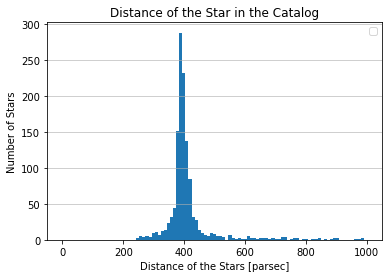

In [14]:
bins = np.linspace(0, 1000, 100)
#plt.hist([mod_vel_2d,mod_vel_ori_2d], bins = bins,
#         label=['Velocity 2d Trapezium Runaways', "Velocity 2d Orion Stars"])

#plt.hist(mod_vel_2d, bins = bins)
plt.hist(1/(parallax_stars), bins = bins)

plt.legend(loc='upper right')
plt.xlabel("Distance of the Stars [parsec]")
plt.ylabel("Number of Stars")
#plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
plt.title("Distance of the Star in the Catalog")
#plt.savefig('ParallaxHistogram.jpg', dpi=300)
plt.show()

## Radial Velocity Errors

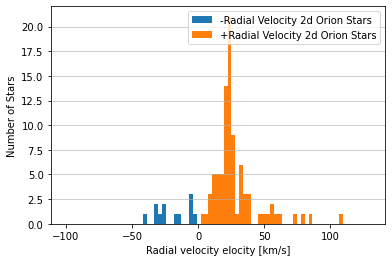

In [15]:
bins = np.linspace(-100, 130, 80)

#plt.hist(mod_vel_2d, bins = bins)
plt.hist(rad_vel[rad_vel<0], bins = bins,label=['-Radial Velocity 2d Orion Stars', "Velocity 2d Orion Stars"])
plt.hist(rad_vel[rad_vel>0], bins = bins,label=['+Radial Velocity 2d Orion Stars', "Velocity 2d Orion Stars"])
plt.legend(loc='upper right')
plt.xlabel("Radial velocity elocity [km/s]")
plt.ylabel("Number of Stars")
#plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
#plt.savefig('2dVelocitiesOrion2.png', dpi=300)
plt.show()

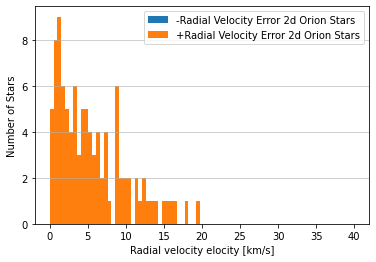

In [16]:
bins = np.linspace(0, 40, 80)

#plt.hist(mod_vel_2d, bins = bins)
plt.hist(rad_vel_err[rad_vel_err<0], bins = bins,label=['-Radial Velocity Error 2d Orion Stars', "Velocity 2d Orion Stars"])
plt.hist(rad_vel_err[rad_vel_err>0], bins = bins,label=['+Radial Velocity Error 2d Orion Stars', "Velocity 2d Orion Stars"])
plt.legend(loc='upper right')
plt.xlabel("Radial velocity elocity [km/s]")
plt.ylabel("Number of Stars")
#plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
#plt.savefig('2dVelocitiesOrion2.png', dpi=300)
plt.show()

# Interaction Analisis Method

## CrossPoint, TracebackLine, angle between Stars and TracebackTime

In [17]:
import itertools as it
run_combinations = []
list = range(0,len(catalog_orion["source_id"]))
for c in it.combinations((list), 2):
    run_combinations.append(c)
len(run_combinations)

835278

In [42]:
def module(a,b):
    c = np.sqrt(a**2 + b**2)
    return c
c

(1291, 1292)

In [44]:
star_s = []
star_b = []
cross_point_stars_x = []
cross_point_stars_y = []
TBL_S=[]#* u.ys
TBL_B=[]#* u.ys
angle_bet_stars = []
VelMod_S=[]#* u.m / u.s
VelMod_B=[]#* u.m / u.s
parallax_S = []
parallax_B = []
parallax_err_S = []
parallax_err_B = []
ruwe_S = []
ruwe_B = []


for i in range(0,len(run_combinations)):
    s = run_combinations[i][0]
    b = run_combinations[i][1]
    
    #Position Single
    pos_s_x, pos_s_y = (x_ref_stars[s],y_ref_stars[s])
    #Velocity Single
    v_s_x, v_s_y = prop_x_ori[s], prop_y_ori[s]
    #Velocity Modules Single
    v_s_mod = module(v_s_x, v_s_y)
    #Norm Single
    nor_s_x, nor_s_y = (v_s_x/v_s_mod,v_s_y/v_s_mod)
    
    #Position Binary
    pos_b_x, pos_b_y =  (x_ref_stars[b],y_ref_stars[b])
    #Velocity Binary
    v_b_x, v_b_y = prop_x_ori[b], prop_y_ori[b]
    #Velocity Modules Binary
    v_b_mod = module(v_b_x,v_b_y)
    #Norm Binary
    nor_b_x, nor_b_y = (v_b_x/v_b_mod,v_b_y/v_b_mod)
    if v_s_mod>0 and v_b_mod>0:
        #Difference in positions of the Stars
        dif_pos_x = pos_s_x - pos_b_x
        dif_pos_y = pos_s_y - pos_b_y
        
        #Angle for the runaways
        angle_run = np.arccos((v_s_x*v_b_x + v_s_y*v_b_y)/(v_s_mod*v_b_mod))
        
        #Matrix of the equation system
        matrix = np.array([[nor_b_x,-nor_s_x],[nor_b_y, -nor_s_y]])
        matrix_res = np.array([dif_pos_x,dif_pos_y])
        matrix_solve = np.linalg.solve(matrix, matrix_res)
        
        if matrix_solve[0] < 0 and matrix_solve[1]<0:
            cross_point_sx = (matrix_solve[1]*nor_s_x + pos_s_x)
            cross_point_sy = (matrix_solve[1]*nor_s_y + pos_s_y)
            
            cross_point_bx = (matrix_solve[0]*nor_b_x + pos_b_x)
            cross_point_by = (matrix_solve[0]*nor_b_y + pos_b_y)
            
            traceback_line_b = module(pos_b_x 
            - cross_point_bx , pos_b_y - cross_point_by)/v_b_mod
            traceback_line_s = module(pos_s_x 
            - cross_point_sx , pos_s_y - cross_point_sy)/v_s_mod          
            
            if abs(traceback_line_b-traceback_line_s)<traceback_line_b/100*20 and angle_run>1.0:
                
                star_s.append(run_combinations[i][0])
                star_b.append(run_combinations[i][1])
                cross_point_stars_x.append(cross_point_sx)
                cross_point_stars_y.append(cross_point_sy)
                TBL_S.append(traceback_line_s*10**3*3600/0.074533) #[yr]
                TBL_B.append(traceback_line_b*10**3*3600/0.074533) #[yr]
                VelMod_S.append(pm_xy_ori_kms[s]) # [km/s]
                VelMod_B.append(pm_xy_ori_kms[b]) # [km/s]
                angle_bet_stars.append(angle_run) #[rad]
                parallax_S.append(parallax_stars[s]*10**3) #[mas]
                parallax_err_S.append(parallax_err_stars[s]*10**3) #[mas] 
                parallax_B.append(parallax_stars[b]*10**3) #[mas]
                parallax_err_B.append(parallax_err_stars[b]*10**3) #[mas]
                ruwe_S.append(ruwe_orion[s]) 
                ruwe_B.append(ruwe_orion[b])
                
T1 = Table([star_s,star_b, cross_point_stars_x, cross_point_stars_y, TBL_S, TBL_B, VelMod_S, VelMod_B, angle_bet_stars, parallax_S, parallax_err_S, parallax_B, parallax_err_B, ruwe_S, ruwe_B],names=("star_s","star_b", "cross_point_x", "cross_point_y", "TBL_S", "TBL_B", "vel_mod_s", "vel_mod_b","angle", "parallax_s","parallax_err_s", "parallax_b","parallax_err_b", "ruwe_s", "ruwe_b"),meta={'name': 'Table_three_body_interactions'})

# Runaways Cases Simple analisis

In [ ]:
T1.write('Interactions_catalog2.csv',format='ascii.csv', overwrite=True)

# Interactions Catalog with cases information

In [43]:
interaction_orion = read_csv("Interactions_catalog2.csv")
interaction_orion

,star_s,star_b,cross_point_x,cross_point_y,TBL_S,TBL_B,vel_mod_s,vel_mod_b,angle,parallax_s,parallax_err_s,parallax_b,parallax_err_b,ruwe_s,ruwe_b
0,0,80,0.001554,-0.006656,173943.048136,150068.975343,1.875670,2.183848,1.209632,2.66,0.053727,2.46,0.033409,1.024041,1.130261
1,0,127,0.001983,-0.006308,146771.824706,175326.565874,1.875670,3.853942,1.351781,2.66,0.053727,2.38,0.059996,1.024041,1.038676
2,0,177,-0.000716,-0.008505,318058.254021,367175.661356,1.875670,2.398009,1.004179,2.66,0.053727,2.56,0.041261,1.024041,1.088091
3,0,256,0.000545,-0.007479,238040.834712,234004.456153,1.875670,3.487615,1.113492,2.66,0.053727,2.57,0.219437,1.024041,0.953895
4,0,286,0.001662,-0.006569,167111.795857,168158.271081,1.875670,2.271864,1.298421,2.66,0.053727,2.49,0.022794,1.024041,1.099309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6696,1242,1257,-0.000129,0.000068,11762.041310,10862.886626,6.376598,1.856676,1.954714,2.21,0.159770,2.50,0.035122,2.308065,0.987461
6697,1243,1280,-0.000393,0.001253,111620.873518,104148.976745,3.961529,6.867910,1.084329,0.79,0.026568,2.65,0.022739,1.022378,1.028691
6698,1257,1280,-0.000943,0.001242,81905.882008,96752.824221,1.856676,6.867910,2.156144,2.50,0.035122,2.65,0.022739,0.987461,1.028691
6699,1257,1283,-0.000814,0.001056,70665.126652,63724.531008,1.856676,14.161361,2.273496,2.50,0.035122,0.72,0.026745,0.987461,1.056542


In [22]:
star_s = interaction_orion["star_s"]
star_b = interaction_orion["star_b"]
vel_mod_s = interaction_orion["vel_mod_s"]
vel_mod_b = interaction_orion["vel_mod_b"]
angle_sb = interaction_orion["angle"]
interaction_orion[(star_s==175) | (star_b==175)]
parallax_s = interaction_orion["parallax_s"]
parallax_b = interaction_orion["parallax_b"]
ruwe_s = interaction_orion["ruwe_s"]
ruwe_b = interaction_orion["ruwe_b"]

# Interaction efectivity Code

## Sort the intaraction with a score value

In [30]:
#Sumatoria de todas las velocidades de la estrellas con las que interacciona
#Condicionar el número de interacciones mínimas = 10
scores=[]
scores_id=[]
bs_max_velocity=999 #Binary Star maximum velocity

interactions_mode=True #if this value is True, the variable below works as a minimum. Else, the number of interactions must be equal to the value below.
bs_rule_interactions=10 #Binary Star rule interactions


for i in range(0,len(interaction_orion)):
    vel_mod_s=interaction_orion.iloc[i]['vel_mod_s']
    vel_mod_b=interaction_orion.iloc[i]['vel_mod_b']
    s=interaction_orion.iloc[i]['star_s']
    b=interaction_orion.iloc[i]['star_b']
    score = 0 #If the binary star does not accomplish the minimum requirements it gets a score of 0
    bs_id = s

    if((vel_mod_b<vel_mod_s) & (vel_mod_b<=bs_max_velocity)): #Filtering by binary star maximum velocity
        n_interactions=star_b[(star_b==b)|(star_s==b)].count()        
        if(interactions_mode):
            if(n_interactions>=bs_rule_interactions):
                vel_sum=sum(interaction_orion.vel_mod_s[(star_b==b)])
                score=vel_sum/n_interactions
                bs_id=b
        elif(n_interactions==bs_rule_interactions):
            vel_sum=sum(interaction_orion.vel_mod_s[(star_b==b)])
            score=vel_sum/n_interactions
            bs_id=b

    elif((vel_mod_s<vel_mod_b) & (vel_mod_s<=bs_max_velocity)):
        n_interactions=star_s[(star_s==s)|(star_b==s)].count()
        if(interactions_mode):
            if(n_interactions>=bs_rule_interactions):
                vel_sum=sum(interaction_orion.vel_mod_b[(star_s==s)])
                score=vel_sum/n_interactions
                bs_id=s
        elif(n_interactions==bs_rule_interactions):
            vel_sum=sum(interaction_orion.vel_mod_b[(star_s==s)])
            score=vel_sum/n_interactions
            bs_id=s
        

    scores.append(score)
    scores_id.append(bs_id)

test_interactions = interaction_orion
test_interactions["star_score"]=scores
test_interactions["star_score_ID"]=scores_id

test_interactions = test_interactions.sort_values(axis='index',kind='quicksort',by="star_score", ascending=False)

In [47]:
test_interactions.columns.to_list()

['star_s',
 'star_b',
 'cross_point_x',
 'cross_point_y',
 'TBL_S',
 'TBL_B',
 'vel_mod_s',
 'vel_mod_b',
 'angle',
 'parallax_s',
 'parallax_err_s',
 'parallax_b',
 'parallax_err_b',
 'ruwe_s',
 'ruwe_b',
 'star_score',
 'star_score_ID']

In [31]:
bs_min_score=-1
bs_max_score=18 #Max 33
max_to_display=5000
allow_duplicate=False

if(allow_duplicate):
   x=test_interactions[(test_interactions["star_score"]>bs_min_score) & (test_interactions["star_score"]<bs_max_score)]
else:
   x=test_interactions[(test_interactions["star_score"]>bs_min_score) & (test_interactions["star_score"]<bs_max_score)].drop_duplicates(subset="star_score")

# Select star to plot
h=1000
x.head(max_to_display)
# x.loc[x["vel_mod_b"]>20]
x

,star_s,star_b,cross_point_x,cross_point_y,TBL_S,TBL_B,vel_mod_s,vel_mod_b,angle,parallax_s,parallax_err_s,parallax_b,parallax_err_b,ruwe_s,ruwe_b,star_score,star_score_ID
6189,895,1083,0.004180,0.007161,13423.446633,14057.636732,21.806475,17.817426,1.922535,0.52,0.018399,3.56,0.027920,1.007571,1.503119,14.594824,1083.0
874,81,1174,-0.002981,-0.000095,28780.547130,33514.252214,22.582380,6.485137,1.133644,2.68,0.016208,1.04,0.815937,1.007610,0.669704,10.810689,1174.0
6499,1026,1284,-0.007126,0.003158,30097.114921,31436.528243,32.204933,18.190671,2.228702,2.67,0.024490,0.86,0.077445,1.135577,0.995108,9.957790,1284.0
519,43,1259,-0.004415,-0.001104,49685.986083,51960.493762,22.977904,11.323559,1.963064,2.83,0.024015,0.72,0.119691,1.019779,1.017593,9.159649,1259.0
933,86,1150,-0.005862,-0.002676,71899.698393,70465.052013,10.195609,8.184965,1.694372,1.81,0.715334,2.96,0.641193,3.195224,4.046140,8.259473,1150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,75,255,-0.000714,0.000576,822564.191751,923511.776587,0.956579,0.447877,1.246710,2.60,0.028858,1.82,0.466884,2.256293,2.519632,0.086962,255.0
1488,158,240,-0.003361,0.000414,122948.490647,137064.993932,2.963477,1.786718,2.180888,2.59,0.039254,2.57,0.069575,1.101444,0.841626,0.084671,240.0
44,7,8,-0.004750,-0.000277,245379.215991,227620.912412,1.848992,1.683472,1.594266,2.39,0.491195,1.12,0.041467,0.393072,1.007274,0.073960,8.0
16,1,21,-0.007837,-0.009154,365121.386288,326065.732311,2.607448,1.969704,1.055179,2.54,0.026223,2.79,0.109381,1.274678,1.433921,0.043457,21.0


# Selection of star with interesting interactions

In [36]:
h=1083.0 #Main interacting star

In [37]:
#Extended list of interactions with the selected star
interaction_orion[(star_s==h) | (star_b==h)]

,star_s,star_b,cross_point_x,cross_point_y,TBL_S,TBL_B,vel_mod_s,vel_mod_b,angle,parallax_s,parallax_err_s,parallax_b,parallax_err_b,ruwe_s,ruwe_b,star_score,star_score_ID
513,43,1083,-0.009195,0.007905,90657.944797,83463.152994,22.977904,17.817426,1.027434,2.83,0.024015,3.56,0.027920,1.019779,1.503119,14.594824,1083.0
573,48,1083,-0.002417,0.007528,56602.206903,48292.391888,27.638156,17.817426,1.619908,1.44,0.039784,3.56,0.027920,1.034969,1.503119,14.594824,1083.0
1061,99,1083,-0.004513,0.007644,57904.144738,59170.856287,19.342268,17.817426,1.623298,2.57,0.018276,3.56,0.027920,1.219088,1.503119,14.594824,1083.0
1332,138,1083,-0.002687,0.007543,49610.682891,49695.478014,8.050684,17.817426,1.633536,1.45,0.018855,3.56,0.027920,1.121462,1.503119,4.735834,138.0
3527,390,1083,-0.006967,0.007781,70929.260455,71902.004338,20.640419,17.817426,1.384934,1.39,0.046634,3.56,0.027920,1.104452,1.503119,14.594824,1083.0
4571,544,1083,0.002525,0.007253,26530.521187,22645.792327,2.301654,17.817426,1.555125,2.46,0.108485,3.56,0.027920,1.012655,1.503119,2.054829,544.0
5737,771,1083,-0.011154,0.008014,105939.059162,93631.322766,14.617797,17.817426,1.033946,2.51,0.015514,3.56,0.027920,1.153769,1.503119,2.910203,771.0
6189,895,1083,0.004180,0.007161,13423.446633,14057.636732,21.806475,17.817426,1.922535,0.52,0.018399,3.56,0.027920,1.007571,1.503119,14.594824,1083.0
6525,1035,1083,-0.008438,0.007863,78255.698056,79535.207606,8.572880,17.817426,1.483384,0.90,0.030333,3.56,0.027920,1.150108,1.503119,0.000000,1035.0
6584,1083,1142,0.000926,0.007342,30946.091823,37113.675116,17.817426,3.058601,1.466278,3.56,0.027920,2.60,0.030161,1.503119,1.041961,0.000000,1083.0


## Plot for the high score star

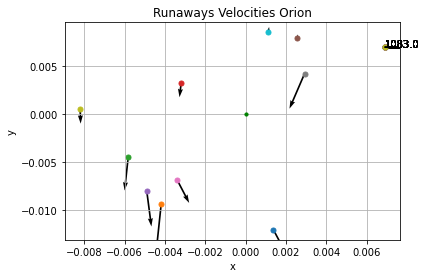

In [40]:
n=(star_s[(star_s==h)|(star_b==h)].append(star_b[(star_s==h)|(star_b==h)])) #Star Number in the Catalog


fig, ax = plt.subplots()
m = h

for i in n:   
    x_pos = x_ref_stars[i] #Pos.x Runaways
    y_pos = y_ref_stars[i] #Pos.y Runaways
    x_direct = prop_x_ori[i] #PropMot Ra Runaways
    y_direct = prop_y_ori[i] #PropMot Dec Runaways
    x_pos_center = x_ref_stars[m] #Pos.x Main Binary
    y_pos_center = y_ref_stars[m] #Pos.y Main Binary
    x_direct_center = prop_x_ori[m] #PropMot Ra Main Binary
    y_direct_center = prop_y_ori[m] #PropMot Dec Main Binary
    
    #Plot Runaways Velocitie Data
    ax.quiver(x_pos, y_pos, x_direct, y_direct, width = 0.005, scale= 100, zorder = 1)
    #Plot the positions of the runaways in the Loop
    plt.scatter(x_ref_stars[i], y_ref_stars[i], marker = ".", s = 100)
    
    #Plot Main Binary Velocitie Data
    ax.quiver(x_pos_center, y_pos_center, x_direct_center, y_direct_center, width = 0.005, scale = 100)

    # plt.text(x_ref_stars[i], y_ref_stars[i], s = i, fontsize = 10) #Star number
    # plt.scatter(x_ref_stars[m], y_ref_stars[m], marker = ".", s = 100)
    plt.text(x_ref_stars[m], y_ref_stars[m], s = m, fontsize = 10)

ax.set_title('Runaways Velocities Orion')

#Plot the positions of Trapezium in the Loop
plt.scatter(0, 0, marker = "o",color ="green", s=10, zorder=2)

plt.xlabel("x")
plt.ylabel("y")
# plt.xlim(-0.01,0.01)
# plt.ylim(-0.01,0.01)
plt.savefig('VelocityOrionStars1.jpg', dpi=300)
plt.grid()
plt.show()

# Interesting Cases


In [41]:
#4218 Lots of stars interacting with the center
#4733 Lots of interactions with high velocity stars
#3462 Interesting ejection directions of the stars
#3496 Interesting ejection directions of the stars
#4220 Lots of interactions with high velocity stars
#3353 Interesting ejection directions of the stars
#4822 This is crazy
#4763 This is crazy V.2
#4698 High Dif
#644  Interesting
#4507 :O
#5126
## Interesting Cases
#4218 Lots of stars interacting with the center
#4733 Lots of interactions with high velocity stars
#3462 Interesting ejection directions of the stars
#3496 Interesting ejection directions of the stars
#4220 Lots of interactions with high velocity stars
#3353 Interesting ejection directions of the stars
#4822 This is crazy

#3    High interaction count
#4698 High Diff
#5200 Highest score with score system v2
#644  :O
#4507 :O
#4822 :O
#2709
#5126
#1167